# Laboratorio 8 — Cliff Walking con Q-learning
**Grupo 1**

Integrantes de grupo:
- **Apaza Villca Cristofer Denilson SIS**
- **Saygua Romero Josue SIS**
- **Romero Morales Jhojan Erick CICO**
- **Peñaranda Anagua Emily SIS**
___
##### **En este cuadernillo se realizó la implementación y demostracion de gymnasiun para cliff walking**
-**Implementación simple y directa de Q-learning:**
- **Tabla Q** para guardar valores
- **Exploración → Explotación**
___
Recompensas:
- -1 por cada paso normal
- -100 por caer en el acantilado
- 0 por llegar a la meta
- **Objetivo: Maximizar recompensa acumulada (minimizar penalizaciones)**
___ 
 En este laboratorio se utiliza un entorno clásico de aprendizaje por refuerzo
 llamado "CliffWalking-v1", proporcionado por la librería Gymnasium

## Instalación de gymnasium
```bash
pip install gymnasium
```

Importamos las librerias que se usará 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import os

np.random.seed(42)


## Creación del entorno Cliff Walking
El entorno **CliffWalking-v1** simula un tablero 4x12 con:
- El agente iniciando en la esquina inferior izquierda.
- La meta al final de la fila inferior derecha.
- Un "acantilado" entre ambos puntos: si el agente cae, recibe una fuerte penalización (-100).

El agente puede moverse **arriba, abajo, izquierda o derecha**.

In [ ]:
# Creamos el entorno para el modelo
env = gym.make('CliffWalking-v1')
print(f'Estados: {env.observation_space.n}')
print(f'Acciones: {env.action_space.n} (0:arriba, 1:derecha, 2:abajo, 3:izquierda)')


Estados: 48
Acciones: 4 (0:arriba, 1:derecha, 2:abajo, 3:izquierda)


## PASO 1: Entrenamiento con Q-learning
Creamos una tabla Q (Q-Table) para almacenar el valor Q(s,a), Q[s, a] representa el valor esperado de tomar la acción 'a' en el estado 's'. Inicialmente todos los valores son 0.

Durante el entrenamiento, el agente interactúa con el entorno durante varios episodios(1500).  
En cada paso decide si **explorar (acción aleatoria)** o **explotar (usar el conocimiento actual)** usando una política ε-greedy.


In [ ]:
n_estados = env.observation_space.n
n_acciones = env.action_space.n
Q = np.zeros((n_estados, n_acciones))

episodios = 1500
alpha = 0.2
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995

historial_recompensas = []

print("Entrenamiento por Q-LEARNING\n")

for ep in range(episodios):
    # Cada episodio es un intento del agente por ir desde el inicio hasta la meta.
    estado, _ = env.reset()
    recompensa_total = 0
    
    for paso in range(200):
        # probabilidad epsilon
        # otras veces explotamos lo que ya aprendimos (la mejor acción según Q).
        if np.random.random() < epsilon:
            accion = env.action_space.sample()  # explorarion
        else:
            accion = int(np.argmax(Q[estado]))  # explotacion
        
        # Ejecutar la acción en el entorno y recibir la recompensa real
        # CliffWalking las recompensas son negativas (cada paso vale -1,caer al acantilado es muy negativo, Aquí eso significa que el agente, está aprendiendo a "perder lo menos posible" llegar rápido y evitar el acantilado)
        nuevo_estado, recompensa, done, truncated, _ = env.step(accion)
        
        # Actualizamos la tabla Q ajustamos cuánto vale esta acción en este estado.
        Q[estado, accion] += alpha * (recompensa + gamma * np.max(Q[nuevo_estado]) - Q[estado, accion])
        
        # Pasamos al siguiente estado
        estado = nuevo_estado
        recompensa_total += recompensa
        
        # Si el episodio terminó, salimos del bucle de pasos
        if done or truncated:
            break
    
    historial_recompensas.append(recompensa_total)
    # Reducimos la exploración lentamente: al principio probamos mucho, luego confiamos en lo aprendido.
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    
    # Mensaje sencillo para mostrar progreso cada 200 episodios
    if (ep + 1) % 200 == 0:
        media = np.mean(historial_recompensas[-100:])
        print(f"Episodio {ep+1}/{episodios} | Recompensa media (últimos 100): {media:.1f} | Epsilon: {epsilon:.2f}")

# Guardamos la tabla Q para poder usarla después sin reentrenar.
np.save('q_table.npy', Q)
print("\n Modelo guardado en: q_table.npy")

Entrenamiento por Q-LEARNING

Episodio 200/1500 | Recompensa media (últimos 100): -380.9 | Epsilon: 0.37
Episodio 400/1500 | Recompensa media (últimos 100): -99.8 | Epsilon: 0.13
Episodio 600/1500 | Recompensa media (últimos 100): -22.3 | Epsilon: 0.05
Episodio 800/1500 | Recompensa media (últimos 100): -20.9 | Epsilon: 0.02
Episodio 1000/1500 | Recompensa media (últimos 100): -18.4 | Epsilon: 0.01
Episodio 1200/1500 | Recompensa media (últimos 100): -15.3 | Epsilon: 0.01
Episodio 1400/1500 | Recompensa media (últimos 100): -16.3 | Epsilon: 0.01

 Modelo guardado en: q_table.npy


## Evolución de la recompensa

La siguiente gráfica muestra cómo cambia la recompensa a lo largo de los episodios.  
Una tendencia ascendente (o menos negativa) indica que el agente está aprendiendo una mejor política.


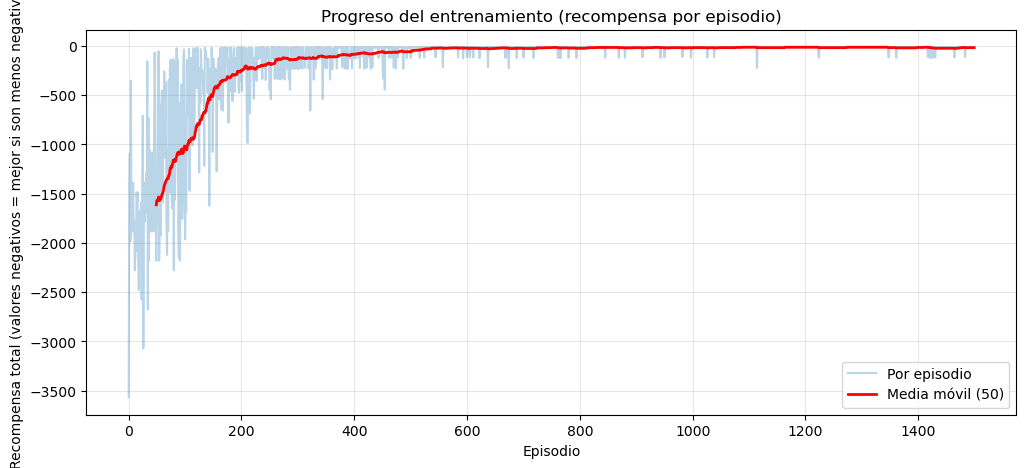


Nota: Las recompensas son negativas por diseño. Un valor menos negativo indica mejor desempeño (menos pasos o evitar el acantilado).


In [ ]:
# Dibujamos la evolución de la recompensa por episodio para ver si el agente mejora
plt.figure(figsize=(12, 5))
plt.plot(historial_recompensas, alpha=0.3, label='Por episodio')

# Media móvil para tener una visión más suave del progreso
ventana = 50
if len(historial_recompensas) >= ventana:
    media_movil = np.convolve(historial_recompensas, np.ones(ventana)/ventana, mode='valid')
    plt.plot(range(ventana-1, len(historial_recompensas)), media_movil, 'r-', linewidth=2, label=f'Media móvil ({ventana})')

plt.xlabel('Episodio')
plt.ylabel('Recompensa total (valores negativos = mejor si son menos negativos)')
plt.title('Progreso del entrenamiento (recompensa por episodio)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#En este entorno una recompensa menos negativa (por ejemplo -13) es mejor que -50.
print('\nLas recompensas son negativas por diseño. Un valor menos negativo indica mejor desempeño (menos pasos o evitar el acantilado).')

## PASO 2: Evaluación del modelo
Probamos el agente sin exploración (solo explotación) para medir qué tan bien aprendió. Se considera éxito si llega a la meta sin caer al acantilado.

In [6]:
#voy a ejecutar el agente sin exploración y contar éxitos
exitos = 0
n_pruebas = 100
pasos_por_prueba = []

print(" EVALUANDO MODELO...\n")

for prueba in range(n_pruebas):
    estado, _ = env.reset()
    pasos = 0
    for paso in range(200):
        # Siempre explotamos la mejor acción conocida
        accion = int(np.argmax(Q[estado]))
        estado, recompensa, done, truncated, _ = env.step(accion)
        pasos += 1
        if done or truncated:
            # En CliffWalking, recompensa > -50 indica que llegó a la meta (-1 normalmente)
            if recompensa > -50:
                exitos += 1
            if prueba < 3:
                print(f"Prueba {prueba+1}: {'✓ Éxito' if recompensa > -50 else '✗ Falló'} ({pasos} pasos)")
            break
    pasos_por_prueba.append(pasos)

porcentaje_exito = (exitos / n_pruebas) * 100
pasos_medios = np.mean(pasos_por_prueba)

print("\n RESULTADOS FINALES")
print(f"✓ Porcentaje de éxito: {porcentaje_exito:.1f}%")
print(f"✓ Pruebas exitosas: {exitos}/{n_pruebas}")
print(f"✓ Pasos medios por intento: {pasos_medios:.1f}")


 EVALUANDO MODELO...

Prueba 1: ✓ Éxito (13 pasos)
Prueba 2: ✓ Éxito (13 pasos)
Prueba 3: ✓ Éxito (13 pasos)

 RESULTADOS FINALES
✓ Porcentaje de éxito: 100.0%
✓ Pruebas exitosas: 100/100
✓ Pasos medios por intento: 13.0


## PASO 3: Visualizar política aprendida
Mostramos la política aprendida (acción óptima por estado). Cada flecha representa la dirección que el agente elige con mayor valor Q. Esto permite visualizar la ruta aprendida para evitar el acantilado.


In [ ]:
# Mostrar la política de forma legible: flechas que indican la mejor acción en cada casilla
acciones_simbolos = {0: '↑', 1: '→', 2: '↓', 3: '←'}
politica = np.argmax(Q, axis=1)

print("POLÍTICA APRENDIDA \n")
for fila in range(4):
    linea = ""
    for col in range(12):
        estado = fila * 12 + col
        accion = int(politica[estado])
        linea += f" {acciones_simbolos[accion]} "
    print(linea)


POLÍTICA APRENDIDA (leer fila por fila):

 ←  →  →  →  ↓  →  →  ↓  →  ↓  →  ↓ 
 ↓  →  →  ↓  →  ↓  ↓  ↓  →  →  ↓  ↓ 
 →  →  →  →  →  →  →  →  →  →  →  ↓ 
 ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑ 

Nota: S = inicio (abajo izquierda), G = meta (abajo derecha).
Lee las flechas como: si estás en esa casilla, la flecha es el movimiento que el agente prefiere.


## PASO 4: Cargar modelo guardado
Cargamos el archivo con la Q-table entrenada y verificamos su funcionamiento.
Se realizan 5 ejecuciones de prueba y se muestra el resultado de cada una.


In [8]:
# Cargar la Q-table guardada y ejecutar un par de episodios para comprobar que todo funciona
Q_guardado = np.load('q_table.npy')
print("Modelo cargado desde: q_table.npy\n")

print("Probando el modelo cargado (5 ejecuciones):\n")
for i in range(5):
    estado, _ = env.reset()
    pasos = 0
    for paso in range(200):
        accion = int(np.argmax(Q_guardado[estado]))
        estado, recompensa, done, truncated, _ = env.step(accion)
        pasos += 1
        if done or truncated:
            print(f"Ejecución {i+1}: {'✓ Éxito' if recompensa > -50 else '✗ Falló'} ({pasos} pasos)")
            break

print('\nNota: si quieres reproducir exactamente, garantiza la semilla al resetear el env.')

Modelo cargado desde: q_table.npy

Probando el modelo cargado (5 ejecuciones):

Ejecución 1: ✓ Éxito (13 pasos)
Ejecución 2: ✓ Éxito (13 pasos)
Ejecución 3: ✓ Éxito (13 pasos)
Ejecución 4: ✓ Éxito (13 pasos)
Ejecución 5: ✓ Éxito (13 pasos)

Nota: si quieres reproducir exactamente, garantiza la semilla al resetear el env.


## PASO 5: Demostración visual
Por último, se crea una versión del entorno con modo gráfico (`render_mode='human'`)  
para observar visualmente cómo el agente recorre el camino aprendido.
Creamos un entorno con renderizado visual para observar la ruta.
Cada paso se retrasa 0.2 segundos para ver el movimiento.
El bucle se detiene si el agente alcanza la meta o cae.


In [11]:
import time

env_visual = gym.make('CliffWalking-v1', render_mode='human')
estado, _ = env_visual.reset()

for paso in range(200):
    accion = np.argmax(Q[estado])
    estado, recompensa, done, truncated, _ = env_visual.step(accion)
    time.sleep(0.2)
    
    if done or truncated:
        print(f"✓ Completado en {paso+1} pasos")
        break

env_visual.close()


✓ Completado en 13 pasos
